In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip uninstall -y pretrainedmodels
# !pip uninstall -y efficientnet-pytorch
# !pip uninstall -y timm
# !pip uninstall -y segmentation-models-pytorch

In [ ]:
%%writefile requirements.txt
torchvision>=0.5.0
pretrainedmodels==0.7.4
efficientnet-pytorch==0.7.1
#timm==0.9.7
timm
tqdm
pillow
six

Overwriting requirements.txt


In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install -U segmentation-models-pytorch albumentations --user

## Loading data

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
######################################################################
######################################################################
BASE_DIR = '/content/drive/MyDrive/project3'
DATA_DIR = os.path.join(BASE_DIR, 'Dataset')

x_train_dir = os.path.join(DATA_DIR, 'images_prepped_train')
y_train_dir = os.path.join(DATA_DIR, 'annotations_prepped_train')

x_test_dir = os.path.join(DATA_DIR, 'images_prepped_test')
y_test_dir = os.path.join(DATA_DIR, 'annotations_prepped_test')
######################################################################
######################################################################

In [ ]:
print(len(os.listdir(x_train_dir)))
print(len(os.listdir(y_train_dir)),'\n')

print(len(os.listdir(x_test_dir)))
print(len(os.listdir(y_test_dir)))

398
367 

101
101


### Dataloader

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
class Dataset(BaseDataset):
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabeled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        # Treatment untuk data duplikasi pada folder training:
        # dilakukan croscheck data pada masing2 folder
        ids_all = os.listdir(images_dir) # list file gambar awal
        mask_all = os.listdir(masks_dir) # list file mask
        np_ids_all = np.asarray(ids_all)
        np_ids_all = np_ids_all[np.isin(np_ids_all, mask_all)]
        np_mask_all = np.asarray(mask_all)
        np_mask_all = np_mask_all[np.isin(np_mask_all, ids_all)]

        self.ids =np_ids_all.tolist() # self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing


    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

### Showing Data

In [ ]:
show_dataset = Dataset(x_train_dir, y_train_dir, classes=Dataset.CLASSES)

image:354


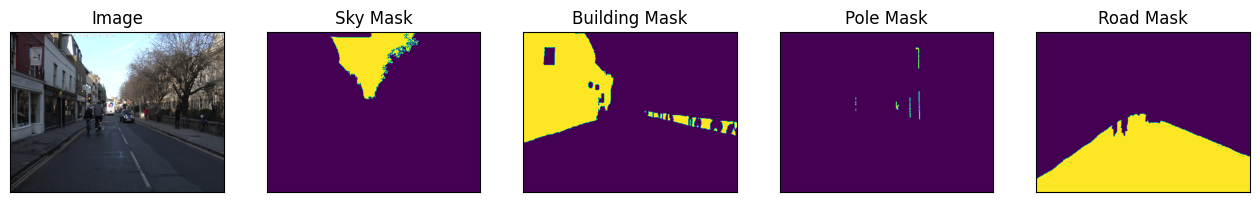

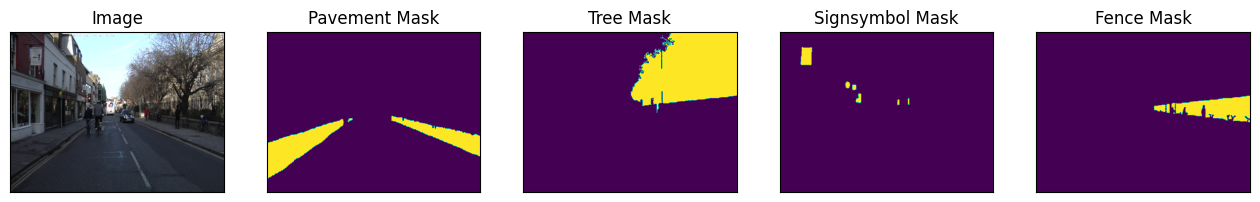

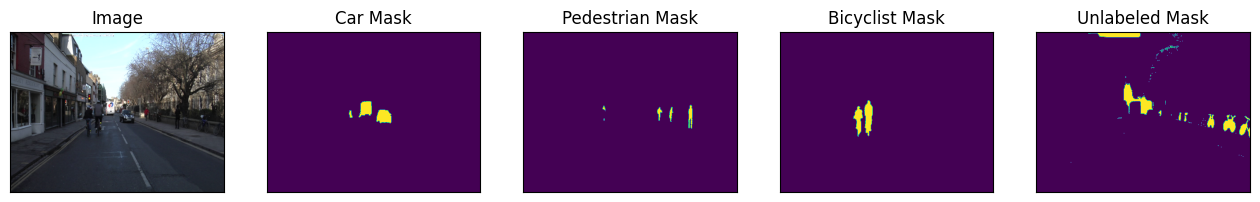

In [ ]:
show_id = np.random.randint(0, len(show_dataset)) #226
image, mask = show_dataset[show_id]

print(f'image:{show_id}')

visualize(
    image=image,
    sky_mask=mask[..., 0].squeeze(),
    building_mask=mask[..., 1].squeeze(),
    pole_mask=mask[..., 2].squeeze(),
    road_mask=mask[..., 3].squeeze(),
)

visualize(
    image=image,
    pavement_mask=mask[..., 4].squeeze(),
    tree_mask=mask[..., 5].squeeze(),
    signsymbol_mask=mask[..., 6].squeeze(),
    fence_mask=mask[..., 7].squeeze(),
)

visualize(
    image=image,
    car_mask=mask[..., 8].squeeze(),
    pedestrian_mask=mask[..., 9].squeeze(),
    bicyclist_mask=mask[..., 10].squeeze(),
    unlabeled_mask=mask[..., 11].squeeze(),
)

### Data Augmentations

In [ ]:
import albumentations as albu

In [ ]:
IMG_HEIGHT = 360
IMG_WIDTH = 480

IMG_HEIGHT_MIN = 352
IMG_HEIGHT_PAD = 384

def get_training_augmentation():
    return albu.Resize(IMG_HEIGHT_MIN, IMG_WIDTH, p=1, always_apply=True)

    train_transform = [
        # albu.Resize(IMG_HEIGHT_MIN, IMG_WIDTH, p=1, always_apply=True),
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        # albu.Resize(256, 256, p=1, always_apply=True),
        albu.Resize(IMG_HEIGHT_MIN, IMG_HEIGHT_MIN, p=1, always_apply=True),

        albu.PadIfNeeded(min_height=IMG_HEIGHT_MIN, min_width=IMG_HEIGHT_MIN, always_apply=True, border_mode=0),
        albu.RandomCrop(height=IMG_HEIGHT_MIN, width=IMG_HEIGHT_MIN, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]

    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(IMG_HEIGHT_MIN, IMG_WIDTH, p=1, always_apply=True),
        # albu.PadIfNeeded(IMG_HEIGHT_PAD, IMG_WIDTH)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

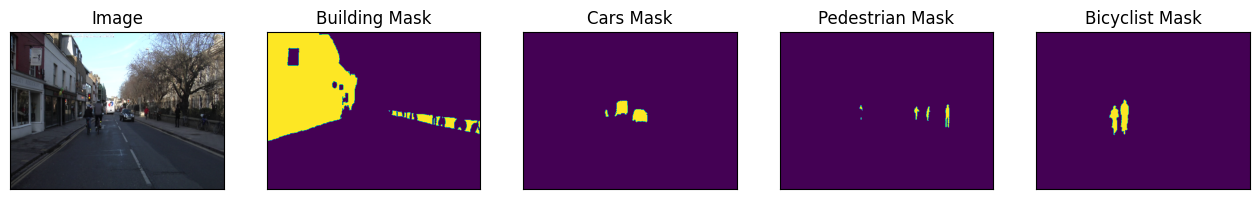

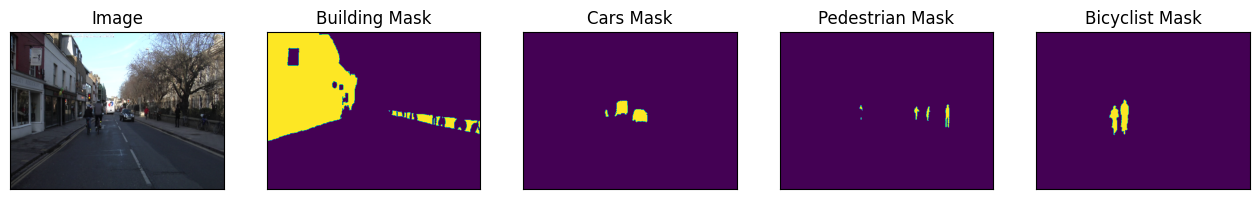

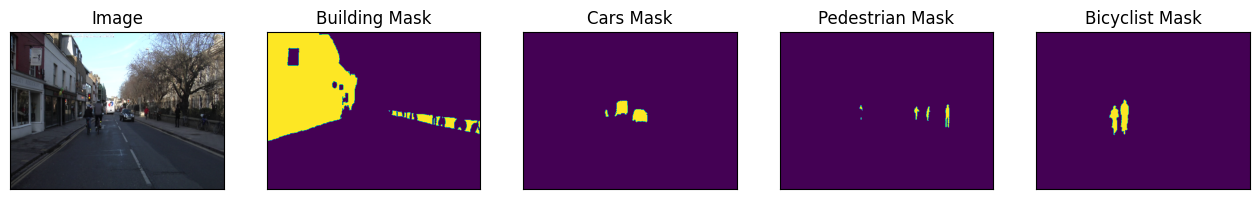

In [ ]:
#### Visualize resulted augmented images and masks

aug_dataset = Dataset(x_train_dir, y_train_dir,
                      augmentation=get_training_augmentation(),
                      classes=Dataset.CLASSES)

# same image with different random transforms
for i in range(3):
    image, mask = aug_dataset[show_id]
    visualize(
        image=image,
        building_mask=mask[..., 1].squeeze(),
        cars_mask=mask[..., 8].squeeze(),
        pedestrian_mask=mask[..., 9].squeeze(),
        bicyclist_mask=mask[..., 10].squeeze(),)

## Create model and train

In [ ]:
# Current 'hack' untuk mengatasi library ' segmentation-models-pytorch' yg masih sering error:
# 1. uninstall library segmentation-models-pytorch
# 2. install library timm
# 3. install ulang library segmentation-models-pytorch

!pip uninstall -y segmentation-models-pytorch

Found existing installation: segmentation-models-pytorch 0.3.3
Uninstalling segmentation-models-pytorch-0.3.3:
  Successfully uninstalled segmentation-models-pytorch-0.3.3


In [ ]:
!pip install -U timm --user

  Using cached timm-0.9.12-py3-none-any.whl (2.2 MB)
  Attempting uninstall: timm
    Found existing installation: timm 0.9.2
    Uninstalling timm-0.9.2:
      Successfully uninstalled timm-0.9.2


In [ ]:
!pip install -U segmentation-models-pytorch

  Using cached segmentation_models_pytorch-0.3.3-py3-none-any.whl (106 kB)
  Using cached timm-0.9.2-py3-none-any.whl (2.2 MB)
  Attempting uninstall: timm
    Found existing installation: timm 0.9.12
    Uninstalling timm-0.9.12:
      Successfully uninstalled timm-0.9.12


In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
######################################################################
######################################################################
# ENCODER = efficientnet-b4'
# ENCODER = 'resnet50'
ENCODER = 'resnet101'

ENCODER_WEIGHTS = 'imagenet'

CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
           'tree', 'signsymbol', 'fence', 'car',
           'pedestrian', 'bicyclist', 'unlabeled']

ACTIVATION = 'softmax2d'
######################################################################
######################################################################

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 288MB/s]


In [ ]:
######################################################################
######################################################################
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
# preprocessing_fn = None

train_batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42
######################################################################
######################################################################

from torch.utils.data.sampler import SubsetRandomSampler

aug_train_dataset = Dataset(x_train_dir, y_train_dir,
                            augmentation=get_training_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn),
                            classes=CLASSES)

# Training and Validation splits:
dataset_size = len(aug_train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(aug_train_dataset, batch_size=train_batch_size, sampler=train_sampler)
valid_loader = DataLoader(aug_train_dataset, batch_size=1, sampler=valid_sampler)
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
# valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)


In [ ]:
######################################################################
######################################################################
LR = 0.001
######################################################################
######################################################################

# https://github.com/qubvel/segmentation_models.pytorch/issues/635
import segmentation_models_pytorch.utils.losses
import segmentation_models_pytorch.utils.metrics

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(),
    # smp.utils.metrics.Fscore()
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=LR),
])

In [ ]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
######################################################################
######################################################################
EPOCHS = 50
######################################################################
######################################################################

In [ ]:
# set file name to best model
from datetime import datetime
import pytz

jkt_tz = pytz.timezone('Asia/Jakarta')
now_jkt = datetime.now(jkt_tz)
str_jkt = now_jkt.strftime("%y%m%d_%H%M")

######################################################################
fname = f'{str_jkt}__p3_12_unet_qubvel_{ENCODER}_{ENCODER_WEIGHTS}_{EPOCHS}'
######################################################################

print(fname)

240205_2130__p3_12_unet_qubvel_resnet101_imagenet_50


In [ ]:
# train model
_best_model = None
max_score = 0

x_epoch_data = []
train_dice_loss = []
train_acc_score = []
valid_dice_loss = []
valid_acc_score = []
train_iou_score = []
valid_iou_score = []

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for i in range(0, EPOCHS):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    x_epoch_data.append(i)

    train_dice_loss.append(train_logs['dice_loss'])
    train_acc_score.append(train_logs['accuracy'])
    train_iou_score.append(train_logs['iou_score'])

    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_acc_score.append(valid_logs['accuracy'])
    valid_iou_score.append(valid_logs['iou_score'])

    # if max_score < valid_logs['accuracy']:
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        # max_score = valid_logs['accuracy']
        torch.save(model, fname + '.pth')
        _best_model = model
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

    if i == 50:
        optimizer.param_groups[0]['lr'] = 5e-6
        print('Decrease decoder learning rate to 5e-6!')

    if i == 75:
        optimizer.param_groups[0]['lr'] = 1e-6
        print('Decrease decoder learning rate to 1e-6!')

end.record()

# Waits for everything to finish running
# torch.cuda.synchronize()

duration = start.elapsed_time(end) / 60000
print(f'Time elapsed: {round(duration,2)} minutes')


Epoch: 0
valid: 100%|██████████| 73/73 [00:42<00:00,  1.73it/s, dice_loss - 0.5344, iou_score - 0.3387, accuracy - 0.9198]
Model saved!

Epoch: 1
valid: 100%|██████████| 73/73 [00:06<00:00, 11.17it/s, dice_loss - 0.3275, iou_score - 0.5929, accuracy - 0.9603]
Model saved!

Epoch: 2
valid: 100%|██████████| 73/73 [00:06<00:00, 11.22it/s, dice_loss - 0.2365, iou_score - 0.6605, accuracy - 0.9664]
Model saved!

Epoch: 3
valid: 100%|██████████| 73/73 [00:06<00:00, 10.73it/s, dice_loss - 0.2437, iou_score - 0.6454, accuracy - 0.9632]

Epoch: 4
valid: 100%|██████████| 73/73 [00:06<00:00, 11.40it/s, dice_loss - 0.1998, iou_score - 0.6892, accuracy - 0.9687]
Model saved!

Epoch: 5
valid: 100%|██████████| 73/73 [00:07<00:00, 10.39it/s, dice_loss - 0.1939, iou_score - 0.6938, accuracy - 0.969]
Model saved!

Epoch: 6
valid: 100%|██████████| 73/73 [00:06<00:00, 11.89it/s, dice_loss - 0.1831, iou_score - 0.7081, accuracy - 0.9709]
Model saved!

Epoch: 7
valid: 100%|██████████| 73/73 [00:06<00:00, 1

In [ ]:
# save .pth to drive
RESULT_DIR = os.path.join(BASE_DIR, 'results')

if _best_model is not None:
    os.makedirs(RESULT_DIR, exist_ok=True)
    torch.save(_best_model, os.path.join(RESULT_DIR, fname + '.pth'))

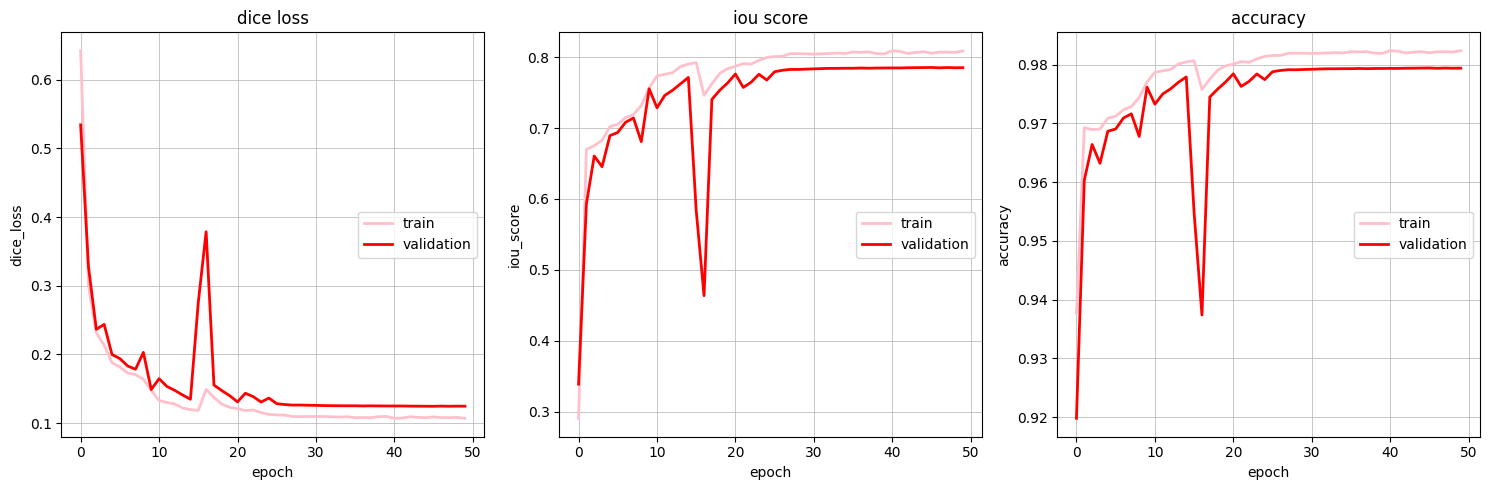

In [ ]:
fig = plt.figure(figsize=(15, 5))

# Subplot 1: dice loss
ax1 = fig.add_subplot(1, 3, 1)
line1, = ax1.plot(x_epoch_data, train_dice_loss, label='train', color='pink', linewidth=2)
line2, = ax1.plot(x_epoch_data, valid_dice_loss, label='validation', color='red', linewidth=2)
ax1.set_title("dice loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('dice_loss')
ax1.legend(loc='center right')
ax1.grid(True, linewidth=0.5)

# Subplot 2: iou score
ax2 = fig.add_subplot(1, 3, 2)
line1, = ax2.plot(x_epoch_data, train_iou_score, label='train', color='pink', linewidth=2)
line2, = ax2.plot(x_epoch_data, valid_iou_score, label='validation', color='red', linewidth=2)
ax2.set_title("iou score")
ax2.set_xlabel('epoch')
ax2.set_ylabel('iou_score')
ax2.legend(loc='center right')
ax2.grid(True, linewidth=0.5)

# Subplot 3: accuracy
ax3 = fig.add_subplot(1, 3, 3)
line1, = ax3.plot(x_epoch_data, train_acc_score, label='train', color='pink', linewidth=2)
line2, = ax3.plot(x_epoch_data, valid_acc_score, label='validation', color='red', linewidth=2)
ax3.set_title("accuracy")
ax3.set_xlabel('epoch')
ax3.set_ylabel('accuracy')
ax3.legend(loc='center right')
ax3.grid(True, linewidth=0.5)

plt.tight_layout()
plt.show()


## Test best saved model

In [ ]:
# load best saved checkpoint
best_model = torch.load('./' + fname + '.pth')

In [ ]:
# create test dataset
aug_test_dataset = Dataset(x_test_dir, y_test_dir,
                           augmentation=get_validation_augmentation(),
                           preprocessing=get_preprocessing(preprocessing_fn),
                           classes=CLASSES)

test_dataloader = DataLoader(aug_test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(model=best_model,
                                        loss=loss,
                                        metrics=metrics,
                                        device=DEVICE)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 101/101 [01:03<00:00,  1.60it/s, dice_loss - 0.1183, iou_score - 0.7906, accuracy - 0.9804]


## Visualize predictions

### Masks result

In [ ]:
# test dataset without transformations for image visualization
test_dataset = Dataset(x_test_dir, y_test_dir, classes=CLASSES)

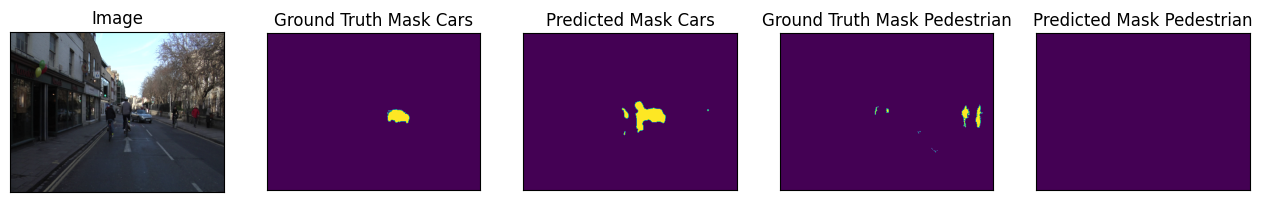

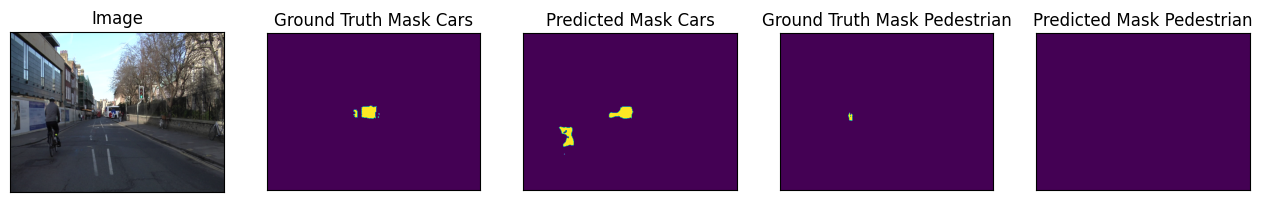

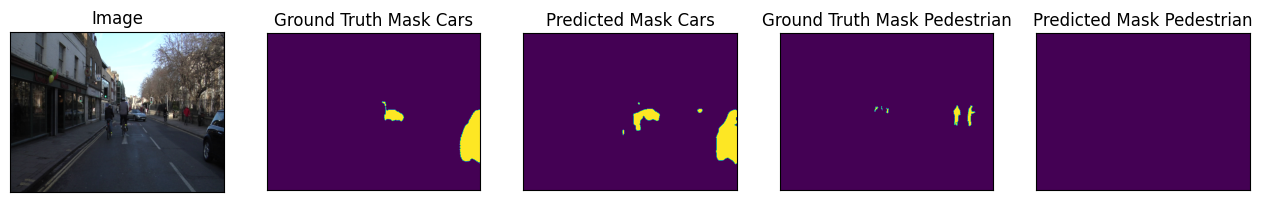

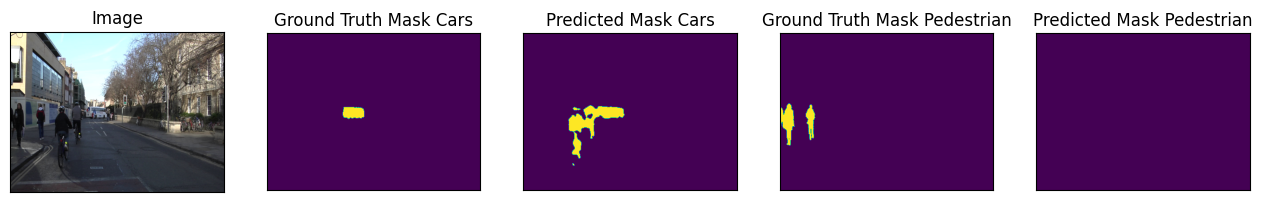

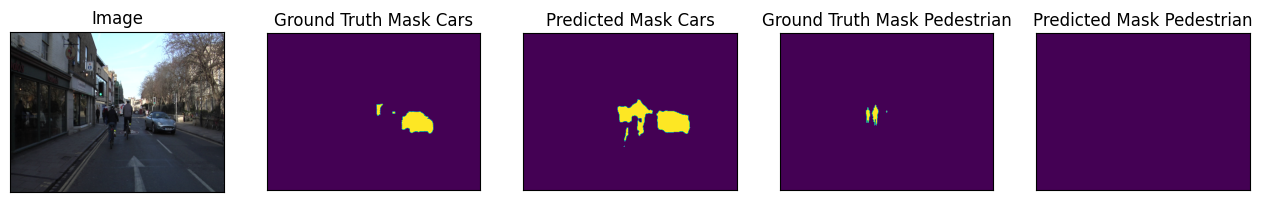

In [ ]:
# Show five random images with selected masks
for i in range(5):
    n = np.random.choice(len(aug_test_dataset))

    image_vis = test_dataset[n][0].astype('uint8')
    image, gt_mask = aug_test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis,
        ground_truth_mask_cars=gt_mask[8],
        predicted_mask_cars=pr_mask[8],
        ground_truth_mask_pedestrian=gt_mask[9],
        predicted_mask_pedestrian=pr_mask[9],
    )

image:15


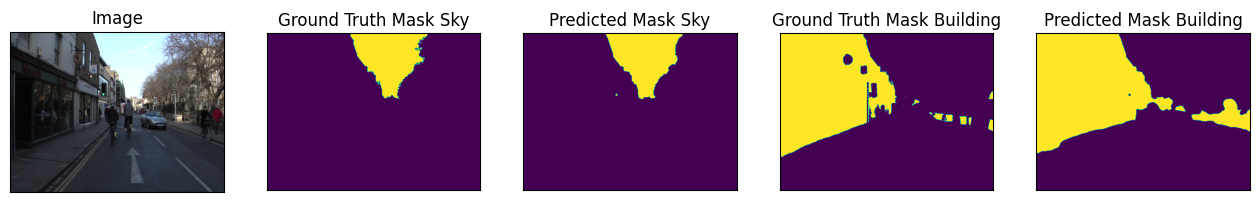

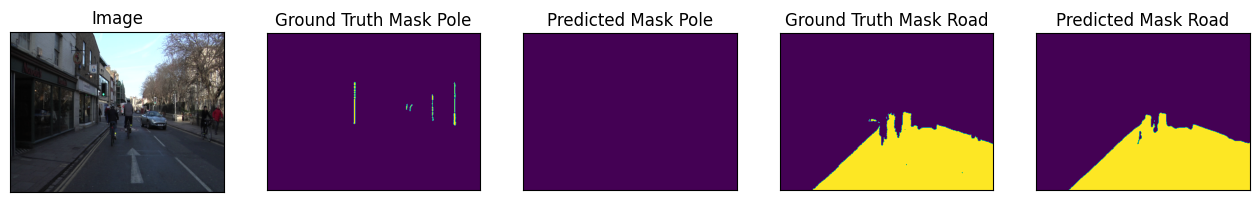

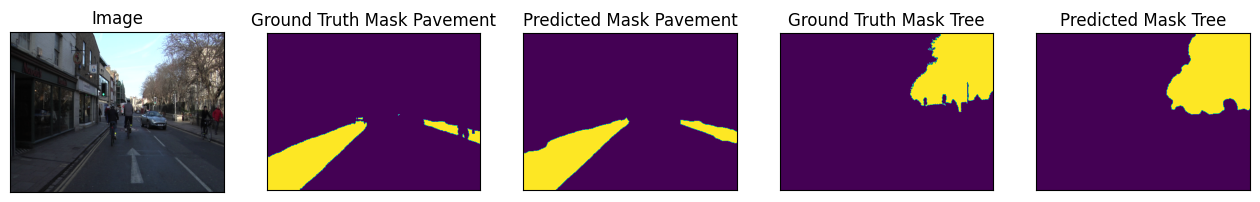

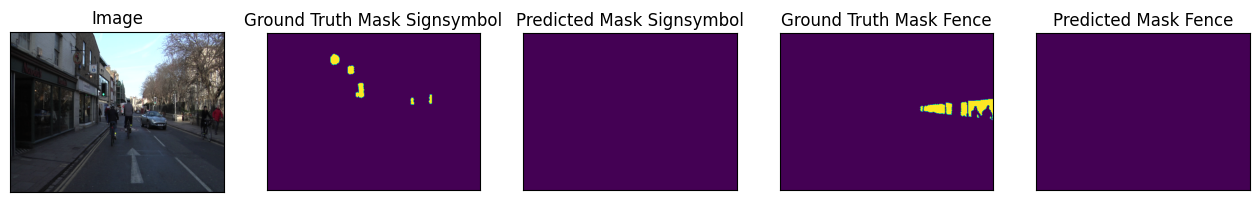

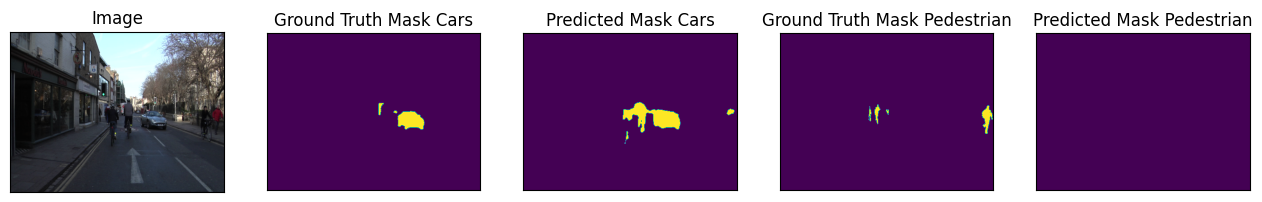

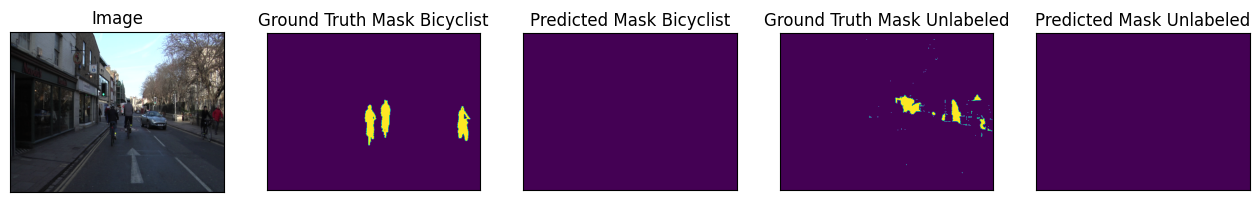

In [ ]:
# Show all masks

n = np.random.choice(len(test_dataset))

image_vis = test_dataset[n][0].astype('uint8')
image, gt_mask = aug_test_dataset[n]

gt_mask = gt_mask.squeeze()

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

print(f'image:{n}')

visualize(
    image=image_vis,
    ground_truth_mask_sky=gt_mask[0],
    predicted_mask_sky=pr_mask[0],
    ground_truth_mask_building=gt_mask[1],
    predicted_mask_building=pr_mask[1],
)
visualize(
    image=image_vis,
    ground_truth_mask_pole=gt_mask[2],
    predicted_mask_pole=pr_mask[2],
    ground_truth_mask_road=gt_mask[3],
    predicted_mask_road=pr_mask[3],
)
visualize(
    image=image_vis,
    ground_truth_mask_pavement=gt_mask[4],
    predicted_mask_pavement=pr_mask[4],
    ground_truth_mask_tree=gt_mask[5],
    predicted_mask_tree=pr_mask[5],
)
visualize(
    image=image_vis,
    ground_truth_mask_signsymbol=gt_mask[6],
    predicted_mask_signsymbol=pr_mask[6],
    ground_truth_mask_fence=gt_mask[7],
    predicted_mask_fence=pr_mask[7],
)
visualize(
    image=image_vis,
    ground_truth_mask_cars=gt_mask[8],
    predicted_mask_cars=pr_mask[8],
    ground_truth_mask_pedestrian=gt_mask[9],
    predicted_mask_pedestrian=pr_mask[9],
)
visualize(
    image=image_vis,
    ground_truth_mask_bicyclist=gt_mask[10],
    predicted_mask_bicyclist=pr_mask[10],
    ground_truth_mask_unlabeled=gt_mask[11],
    predicted_mask_unlabeled=pr_mask[11],
)

### Video Demo

In [ ]:
from tqdm.notebook import tqdm

def create_predict_masks(dataset):
    mask_outputs = []
    for i in tqdm(range(len(dataset))):
        image, gt_mask = dataset[i]
        gt_mask = gt_mask.squeeze()

        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

        pr_mask = best_model.predict(x_tensor)
        pr_mask = (pr_mask.squeeze().cpu().numpy().round())

        mask_outputs.append(pr_mask)

    return mask_outputs

In [ ]:
def create_predict_masks(dataset):
    mask_outputs = []
    for i in tqdm(range(len(dataset))):
        image, gt_mask = dataset[i]
        gt_mask = gt_mask.squeeze()

        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

        pr_mask = best_model.predict(x_tensor)
        pr_mask = (pr_mask.squeeze().cpu().numpy().round())

        mask_outputs.append(pr_mask)

    return mask_outputs

In [ ]:
from matplotlib import animation, rc

# matplotlib.rcParams['animation.embed_limit'] = 200
rc('animation', html='jshtml')

def create_video(images, mask_outputs, save=True, fps=12, repeat=True, suffix_name=None):
    fig = plt.figure()
    plt.axis('off')
    img = []

    for i in tqdm(range(len(images))):
        im1 = images[i][0].astype('uint8')
        im2 = mask_outputs[i]

        im1f = plt.imshow(im1)
        im2f = plt.imshow(im2, alpha=0.3)

        img.append([im1f, im2f])

    ani = animation.ArtistAnimation(fig, img, interval=100, blit=True,
                                    repeat_delay=1000, repeat=repeat)
    plt.close()

    if save:
        base_name = os.path.join(RESULT_DIR, fname) + '_' + str(fps) + 'fps' + (f'_{suffix_name}' if suffix_name is not None else "")
        writer = animation.PillowWriter(fps=fps)
        ani.save(base_name + '.gif', writer=writer)

        writer = animation.FFMpegWriter(fps=fps, metadata=dict(artist='m.fatih.z'), bitrate=1800)
        ani.save(base_name + '.mp4', writer=writer, savefig_kwargs={'facecolor':'black'})

    return ani

##### Video demo

In [ ]:
#  Use test dataset
mask_outputs = create_predict_masks(aug_test_dataset)

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
road_mask = [item[3] for item in mask_outputs]
create_video(test_dataset, road_mask, save=True, fps=6, repeat=False, suffix_name="short")

##### Long video demo (use train dataset)

In [ ]:
train_mask_outputs = create_predict_masks(aug_train_dataset)

  0%|          | 0/367 [00:00<?, ?it/s]

In [ ]:
train_road_mask = [item[3] for item in train_mask_outputs]
create_video(show_dataset, train_road_mask, save=True, fps=6, repeat=True, suffix_name="train")

In [ ]:
print(f'{fname} Completed')

240205_2130__p3_12_unet_qubvel_resnet101_imagenet_50 Completed
